In [1]:
# Transformers installation
! pip install transformers datasets
! pip install evaluate

# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

## Charger le dataset : acouslic_ai_classification dataset

Commencer par charger le dataset préparé pour la classification d'image, depuis la librarie de datasets personnelle "Louloubib" sur le hub de Hugging Face (https://huggingface.co/datasets/Louloubib/acouslic_ai_classification)

In [3]:
from datasets import load_dataset

dataset_classification = load_dataset("Louloubib/acouslic_ai_classification")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/357 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6423 [00:00<?, ? examples/s]

Séparation du dataset en deux partie : entraînement et test avec la méthode [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split):

In [4]:
dataset_classification = dataset_classification["train"].train_test_split(test_size=0.2)

Observons un exemple :

In [5]:
dataset_classification["train"][0]

{'label': 2,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=744x562>,
 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=L size=744x562>}

Chaque exemple a 3 champs :

- `label`: 0, 1 ou 2
- `image`: une image PIL (image échographique)
- `annotation`: une image PIL qui correspond au masque de l'image

Pour faciliter l'obtention du nom de l'étiquette à partir de l'identifiant de l'étiquette par le modèle, créez un dictionnaire qui associe le nom de l'étiquette à un entier, et inversement.

In [6]:
id2label = {
    "0": "no_annotation",
    "1": "optimal",
    "2": "suboptimal",
}

label2id = {"no_annotation": 0, "optimal": 1, "suboptimal": 2}



Nous pouvons maintenant convertir le label en un nom qui lui est associé :

In [7]:
id2label[str(0)]

'no_annotation'

## Pré traitement

Les prochaines étapes consistent en charger un pré processeur (ViT image processor) pour process l'image en en tenseur (une matrice) :

In [8]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Nous appliquons ensuite des transformations à l'image pour éviter que le modèle ne fasse de l'overfitting. Nous utilisons ici le module de torchvision [`transforms`](https://pytorch.org/vision/stable/transforms.html).

Les transformations choisies ici sont :  rogner une partie aléatoire de l'image, la redimensionner, et la normaliser avec la moyenne et l'écart type de l'image.

In [9]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

Nous créons ensuite une fonction de pré traitement pour appliquer ces transformations et qui renvoie les valeurs des pixels `pixels_values` de l'image :

In [10]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    del examples["annotation"]
    return examples

Pour appliquer cette fonction de pré traitement sur le dataset entier, nous utilisons la méthode 🤗 Datasets [with_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.with_transform). Les transformations seront appliquées à chaque chargement d'un nouvel exemple du dataset.

In [11]:
dataset_classification = dataset_classification.with_transform(transforms)

Nous créons maintenant un batch d'exemples en utilisant DefaultDataCollator. Contrairement aux autres data collators dans Hugging Face Transformers, le DefaultDataCollator n'applique pas de prétraitement supplémentaire comme le padding.

In [12]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## Évaluation du modèle

Nous chargons une méthode d'évaluation depuis la librairie Hugging Face Evaluate [Evaluate](https://huggingface.co/docs/evaluate/index).
Pour notre modèle de classification, nous choisissons d'utiliser la précision (accuracy) [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) (voir documentation : [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour)) :

In [13]:
import evaluate

accuracy = evaluate.load("accuracy")

Nous créons ensuite une fonction qui passe les prédictions du modèle et les labels (ground truth) à [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) pour calculer la précision (accuracy) :

In [14]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

La fonction `compute_metrics` est maintenant définie. Nous y reviendrons quand l'entraînement sera paramétré.

## Entraînement

Suivi de la documentation de l'utilisation du [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), avec ce  [tutoriel](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer).

Nous allons pouvoir commencer à entraîner notre modèle. Nous chargons le modèle ViT de Hugging Face Transformers avec [AutoModelForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForImageClassification). Il faut renseigner le nombre de labels, le nombre de labels attendus et le mapping des label :

In [24]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model_name = "acouslic_ai_image_classification-10-epochs"

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Nous allons ensuite :

- Définir les paramètes de l'entraînement ([TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments)).

- Passer les paramètres au [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) avec le modèle, le dataset, les tokenizer, data collector la fonction `compute_metrics`.

- Appeler [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) pour finetuner notre modèle.

Afin de visualiser l'entraînement, il vous faudra un compte wandb.ai et renseigner une clé API (les étapes seront expliquées lorsque la prochaine cellule sera lancée).

In [16]:
training_args = TrainingArguments(
    output_dir=model_name,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset_classification["train"],
    eval_dataset=dataset_classification["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-16-12c2d6eada82>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: louisa-praszezynki (louisa-praszezynki-sorbonne-universit-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.785200,0.771652,0.620233
2,0.713600,0.673102,0.682490
3,0.592600,0.654381,0.683268


KeyboardInterrupt: 

Vous pouvez vous créer un compte sur huggingface.co, ce qui vous permettra de sauvegarder le modèle sur le hub, et le réutiliser facilement par la suite. Il vous faudra alors renseigner un toek (que vous trouverez sur votre compte) et lancer les cellules suivantes [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) :

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer.push_to_hub()

## Inférence

Maintenant que nous avons adapté le modèle à nos besoins (fine-tune), nous pouvons l'utiliser pour le tester/faire de l'inférence.

Chargement d'un exemple sur lequel nous voulons tester le modèle :

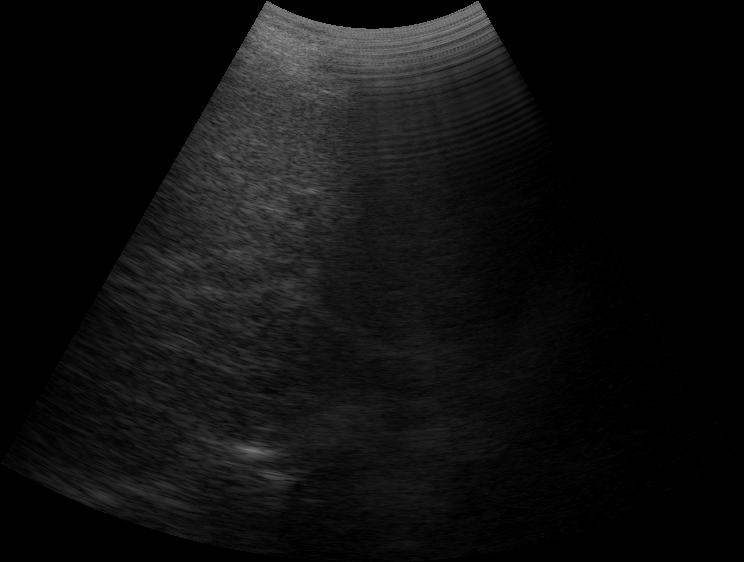

'no_annotation'

In [28]:
ds = load_dataset("Louloubib/acouslic_ai_classification", split="train[:10]")
image = ds["image"][0]
display(image)

ground_truth = ds["label"][0]
display(id2label[str(ground_truth)])

Utilisation de notre modèle et affichage de ses prédictions :

In [27]:
from transformers import pipeline

username = "Louloubib" # à remplacer par votre username du compte huggingface.co si vous en avez créé un

classifier = pipeline("image-classification", model=f"{username}/{model_name}")
classifier(image)

Device set to use cuda:0


[{'label': 'no_annotation', 'score': 0.9770025014877319},
 {'label': 'suboptimal', 'score': 0.014055201783776283},
 {'label': 'optimal', 'score': 0.008942277170717716}]

Et voilà pour notre modèle de classification !